### Collecting dataframes
- Job table dataframe (job_info_df)
- IPMI dataframe (total_power_df)
- Merged dataframe (merged_df)

In [2]:
import os
import pandas as pd
import numpy as np

# defining globals
root_directory = '../data'
job_info_partial_filepath = 'plugin=job_table/metric=job_info_marconi100/a_0_filter123_singlenode.csv'
total_power_partial_filepath = 'plugin=ipmi_pub/metric=total_power/a_0_filter123_singlenode.csv'
column_dtypes = {'resv_name': str, 'wckey': str}
start_time_col = 'start_time'
run_time_col = 'run_time'
end_time_col = 'end_time'
sum_time_col = 'sum_time'
relevant_columns = ['end_time', 'job_id', 'job_state', 'num_cpus', 'num_nodes', 'run_time',
                    'start_time', 'time_limit_str', 'user_id', 'tres_per_node', 'value']
chunk_size = 10000  # Chunk size for merging dataframes without using excessive memory

# Dataframe to store the merged data
merged_df_list = []
job_info__list = []
total_power_list = []

# Iterate through each month folder
for month_folder in os.listdir(root_directory):
    month_path = os.path.join(root_directory, month_folder)

    if os.path.isdir(month_path):
        # Creating full file paths for the job information and total power data files
        job_info_filepath = os.path.join(month_path, job_info_partial_filepath)
        total_power_filepath = os.path.join(month_path, total_power_partial_filepath)

        if os.path.exists(job_info_filepath) and os.path.exists(total_power_filepath):
            # Reading the job information and total power data files in chunks
            job_info_chunks = pd.read_csv(job_info_filepath, dtype=column_dtypes, chunksize=chunk_size)
            total_power_chunks = pd.read_csv(total_power_filepath, chunksize=chunk_size)

            # Iterating through the chunks of job information and total power data, merging them on the 'job_id' column
            for job_info_chunk, total_power_chunk in zip(job_info_chunks, total_power_chunks):
                merged_df_chunk = pd.merge(job_info_chunk, total_power_chunk, on='job_id', how='inner')

                # Append the merged chunk to the list
                merged_df_list.append(merged_df_chunk)
                job_info__list.append(job_info_chunk)
                total_power_list.append(total_power_chunk)

            # Concatenate all chunks into the final merged dataframe
            merged_df = pd.concat(merged_df_list, ignore_index=True)
            job_info_df = pd.concat(job_info__list, ignore_index=True)
            total_power_df = pd.concat(total_power_list, ignore_index=True)

### Cleaning tres_per_node column
- tres_per_node: number of GPU's per node allocated by the user prior to job execution.

In [3]:
merged_df['tres_per_node'].value_counts(dropna=False)

gres:gpu:4    79494
gres:gpu:1     7460
gpu:4          2351
gres:gpu:0     2263
NaN            2220
gres:gpu:2      938
Name: tres_per_node, dtype: int64

In [5]:
# deal with typoed and nan entries
merged_df['tres_per_node'] = merged_df['tres_per_node'].replace('gpu:4', 'gres:gpu:4')
merged_df['tres_per_node'].fillna('gres:gpu:0', inplace=True)

# create new column
merged_df["gpus_per_node"] = merged_df["tres_per_node"].str.replace("gres:gpu:", "").astype("int64")
merged_df["gpus_per_node"].value_counts()

4    81845
1     7460
0     4483
2      938
Name: gpus_per_node, dtype: int64

### Checking data consistency
- Checking that there are no missing values for relevant column
- Check if the timestamps of each node are all separated 20 seconds from each other

In [6]:
# Check for missing values in relevant columns and drop these rows
missing_values = merged_df[relevant_columns].isnull().sum()
if not missing_values.empty and any(missing_values > 0):
    print(f'Missing values:')
    print(missing_values[missing_values > 0])
    merged_df.dropna(subset=relevant_columns, inplace=True)

# Check if timestamps for each node are separated by more than 20 seconds and drop jobs with faulty readings
for job in merged_df['job_id'].unique():
    problematic_rows = []
    node_data = merged_df[merged_df['job_id'] == job].sort_values(by='timestamp')
    node_data['timestamp'] = pd.to_datetime(node_data['timestamp'])

    for i, row in node_data.iterrows():
        if i + 1 < len(node_data):
            next_row = node_data.loc[i + 1]
            if (next_row['timestamp'] - row['timestamp']).total_seconds() != 20.0:
                problematic_rows.append((row, next_row))

    if len(problematic_rows) > 0:
        print(problematic_rows)

In [7]:
print("Total users in the cluster: ", merged_df['user_id'].nunique())
print("Total jobs in the cluster: ", job_info_df['job_id'].nunique())
print("First measurement date: ", merged_df['timestamp'].min())
print("Last measurement date: ", merged_df['timestamp'].max())

Total users in the cluster:  55
Total jobs in the cluster:  442871
First measurement date:  2022-01-01 00:00:00+00:00
Last measurement date:  2022-09-11 21:59:40+00:00


### Plotting run time, power consumption and number of CPUs distributions

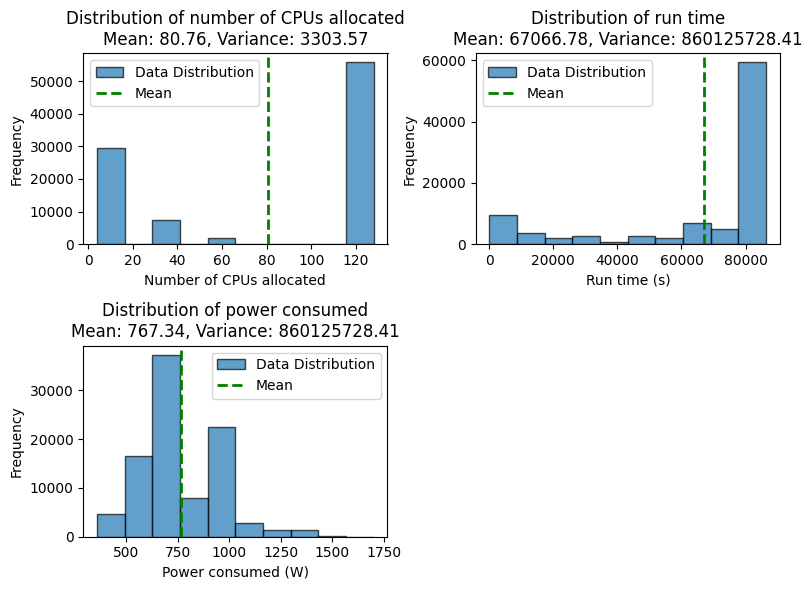

In [6]:
import matplotlib.pyplot as plt

z_score_threshold = 4.0  # z-score threshold for outlier detection
num_cpus = 'num_cpus'
run_time = 'run_time'
power_consumed = 'value'

# Plot distribution with mean, variance, and outliers
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

z_scores = np.abs((merged_df[num_cpus] - merged_df[num_cpus].mean()) / merged_df[num_cpus].std())
axes[0, 0].set_title(f'Distribution of number of CPUs allocated\nMean: {merged_df[num_cpus].mean():.2f}, Variance: {merged_df[num_cpus].var():.2f}')
axes[0, 0].hist(merged_df[num_cpus], bins=10, edgecolor='black', alpha=0.7, label='Data Distribution')
axes[0, 0].axvline(merged_df[num_cpus].mean(), color='green', linestyle='dashed', linewidth=2, label='Mean')
axes[0, 0].set_xlabel('Number of CPUs allocated')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

z_scores = np.abs((merged_df[run_time] - merged_df[run_time].mean()) / merged_df[run_time].std())
axes[0, 1].set_title(f'Distribution of run time\nMean: {merged_df[run_time].mean():.2f}, Variance: {merged_df[run_time].var():.2f}')
axes[0, 1].hist(merged_df[run_time], bins=10, edgecolor='black', alpha=0.7, label='Data Distribution')
axes[0, 1].axvline(merged_df[run_time].mean(), color='green', linestyle='dashed', linewidth=2, label='Mean')
axes[0, 1].set_xlabel('Run time (s)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

z_scores = np.abs((merged_df[power_consumed] - merged_df[power_consumed].mean()) / merged_df[power_consumed].std())
axes[1, 0].set_title(f'Distribution of power consumed\nMean: {merged_df[power_consumed].mean():.2f}, Variance: {merged_df[run_time].var():.2f}')
axes[1, 0].hist(merged_df[power_consumed], bins=10, edgecolor='black', alpha=0.7, label='Data Distribution')
axes[1, 0].axvline(merged_df[power_consumed].mean(), color='green', linestyle='dashed', linewidth=2, label='Mean')
axes[1, 0].set_xlabel('Power consumed (W)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

fig.delaxes(axes[1, 1])

plt.tight_layout()
plt.show()


### Power consupmtion over time for whole system 
Need to align power measurements in IPMI table since some nodes have their power measured at time x and others at y. 

In [41]:
aggregated_power = total_power_df.groupby('timestamp')['value'].sum().reset_index()

aggregated_power

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(aggregated_power['timestamp'], aggregated_power['value'], label='Total Power Consumption')
plt.title('Aggregated Time Series of Power Consumption')
plt.xlabel('Timestamp')
plt.ylabel('Total Power Consumption')
plt.legend()
plt.show()

KeyboardInterrupt: 

In [ ]:
total_power_df.groupby('node')['timestamp'].min()

node
0      2022-04-26 18:51:40+00:00
4      2022-08-14 08:51:20+00:00
21     2022-07-11 07:48:40+00:00
22     2022-07-11 03:34:00+00:00
24     2022-06-10 22:00:00+00:00
                 ...            
958    2022-04-26 15:13:20+00:00
959    2022-04-26 15:27:00+00:00
960    2022-04-26 15:14:00+00:00
961    2022-04-25 22:06:40+00:00
975    2022-04-30 22:00:00+00:00
Name: timestamp, Length: 314, dtype: object

In [ ]:
timestamps_df = total_power_df.sort_values('timestamp')['timestamp'].drop_duplicates()
timestamps_df = pd.to_datetime(timestamps_df)
time_diff = timestamps_df.diff().dt.total_seconds()

problematic_pairs = pd.DataFrame({
    'timestamp1': timestamps_df.iloc[:-1].values,
    'timestamp2': timestamps_df.iloc[1:].values,
    'time_diff': time_diff.iloc[1:].values
})
problematic_pairs[problematic_pairs['time_diff'] != 20.0]

,timestamp1,timestamp2,time_diff
4139,2022-01-01 22:59:40,2022-01-04 23:00:00,259220.0
8459,2022-01-05 22:59:40,2022-02-07 23:00:00,2851220.0
12779,2022-02-08 22:59:40,2022-03-08 23:00:00,2419220.0
17099,2022-03-09 22:59:40,2022-03-25 23:00:00,1382420.0
21419,2022-03-26 22:59:40,2022-04-19 22:00:00,2070020.0
23551,2022-04-20 09:50:20,2022-04-20 10:19:20,1740.0
23641,2022-04-20 10:49:00,2022-04-20 10:50:40,100.0
25649,2022-04-20 21:59:40,2022-04-25 22:06:40,432420.0
26173,2022-04-26 01:01:00,2022-04-26 05:20:40,15580.0
26178,2022-04-26 05:22:00,2022-04-26 05:23:40,100.0


### Visualizing the time series of power consumption for the longest running job in Marconi during 22-08

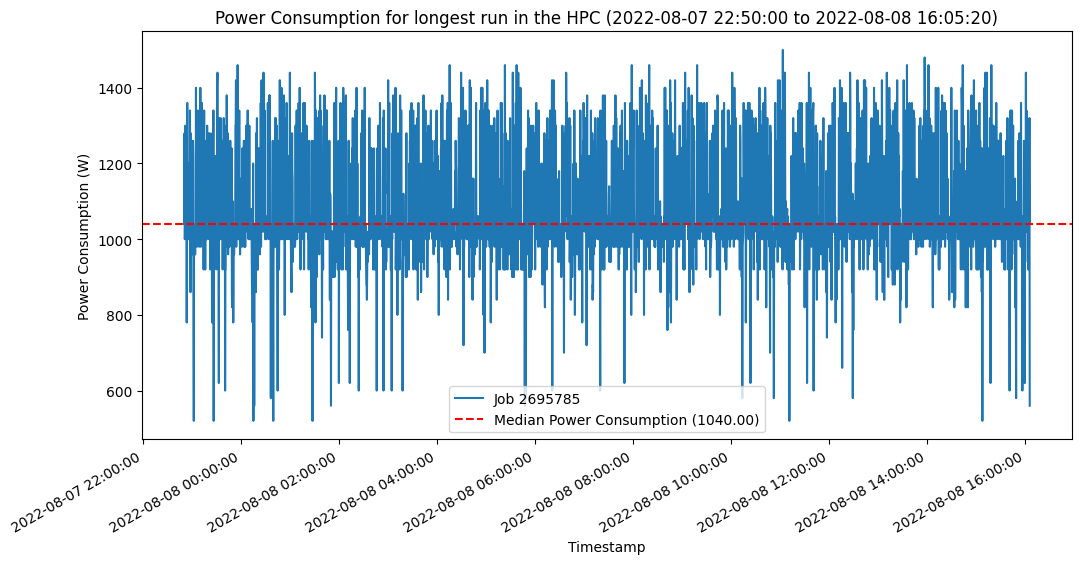

In [7]:
import matplotlib.dates as mdates

timestamp_col = 'timestamp'
runtime_col = 'run_time'
power_col = 'value'

month_path = os.path.join(root_directory, "year_month=22-08")

if os.path.isdir(month_path):
    job_info_filepath = os.path.join(month_path, job_info_partial_filepath)
    total_power_filepath = os.path.join(month_path, total_power_partial_filepath)
    if os.path.exists(job_info_filepath) and os.path.exists(total_power_filepath):
        job_info_chunks = pd.read_csv(job_info_filepath, dtype=column_dtypes, chunksize=chunk_size)
        total_power_chunks = pd.read_csv(total_power_filepath, chunksize=chunk_size)
        time_series_analysis_merged_df = pd.DataFrame()
        for job_info_chunk, total_power_chunk in zip(job_info_chunks, total_power_chunks):
            merged_df_chunk = pd.merge(job_info_chunk, total_power_chunk, on='job_id', how='inner')
            time_series_analysis_merged_df = pd.concat([time_series_analysis_merged_df, merged_df_chunk], ignore_index=True)

    # Find the row corresponding to the longest running job
    longest_running_job_row = time_series_analysis_merged_df.loc[time_series_analysis_merged_df[runtime_col].idxmax()]

    # DataFrame containing the timestamp and power consumption values for the job with the longest run time
    longest_running_job_power = time_series_analysis_merged_df[time_series_analysis_merged_df['job_id'] == longest_running_job_row['job_id']][[timestamp_col, power_col]]

    # Calculate the median of power consumption
    median_power_consumption = longest_running_job_power[power_col].median()

    longest_running_job_power[timestamp_col] = pd.to_datetime(longest_running_job_power[timestamp_col])
    start_time = longest_running_job_power[timestamp_col].min()
    end_time = longest_running_job_power[timestamp_col].max()

    # Plot the time series of power consumption for the longest running job
    plt.figure(figsize=(12, 6))
    plt.plot(longest_running_job_power[timestamp_col], longest_running_job_power[power_col], label=f'Job {longest_running_job_row["job_id"]}')
    plt.axhline(y=median_power_consumption, color='r', linestyle='--', label=f'Median Power Consumption ({median_power_consumption:.2f})')
    plt.title(f'Power Consumption for longest run in the HPC ({mdates.num2date(mdates.date2num(start_time)).strftime("%Y-%m-%d %H:%M:%S")} to {mdates.num2date(mdates.date2num(end_time)).strftime("%Y-%m-%d %H:%M:%S")})')    
    plt.xlabel('Timestamp')
    plt.ylabel('Power Consumption (W)')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    plt.gcf().autofmt_xdate()  # Auto-format the x-axis date labels for better readability
    plt.legend()
    plt.show()

In [8]:
print(start_time, end_time)

2022-08-07 22:50:00+00:00 2022-08-08 16:05:20+00:00


### Applying Fourier Transform to the time series of power consumption for the longest running job

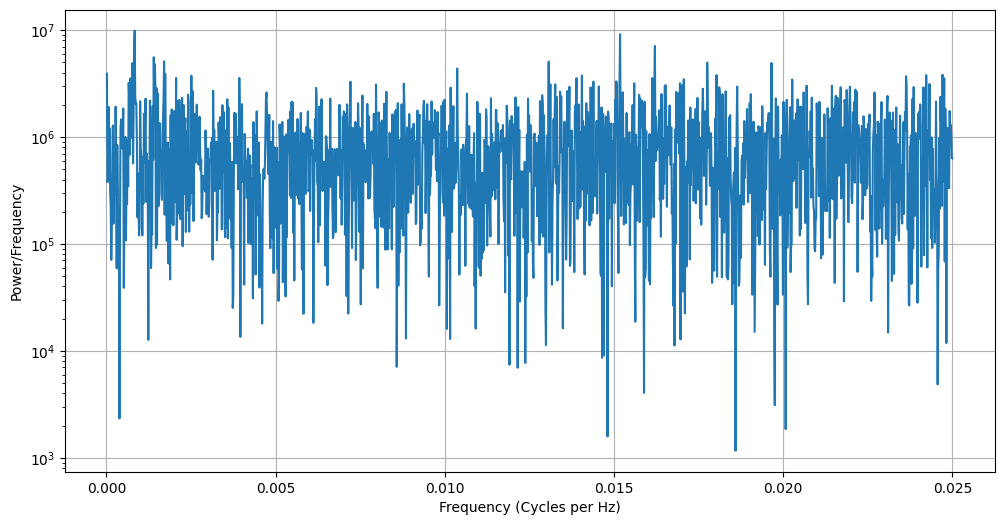

In [9]:
from scipy.signal import periodogram

# ensure timestamps are sorted
longest_running_job_power = longest_running_job_power.sort_values(timestamp_col)

# power consumption values
power_values = longest_running_job_power[power_col].values

# Fourier transform to get periodogram using 1/20 as sampling freq since all timestamps are 20 secs from each other
frequencies, power_spectrum = periodogram(power_values, fs=1/20)

plt.figure(figsize=(12, 6))
plt.semilogy(frequencies[1:], power_spectrum[1:])
plt.xlabel('Frequency (Cycles per Hz)')
plt.ylabel('Power/Frequency')
plt.grid(True)
plt.show()

For example, if there's a strong periodic pattern in the time series that repeats every 24 hours, we might see a peak in the periodogram at a frequency corresponding to 1 cycle per 24 hours (the inverse of the period).

### Setting a threshold and finding periodicity hints

In [10]:
from scipy.signal import find_peaks

max_spectral_powers = []

# Generate permuted sequences, calculate periodogram, record max spectral powers
for _ in range(100):
    permuted_sequence = np.random.permutation(power_values)
    _, spectrum = periodogram(permuted_sequence, fs=1/20)
    max_spectral_powers.append(np.max(spectrum))

threshold = np.sort(max_spectral_powers)[-99]
peaks, _ = find_peaks(power_spectrum, height=threshold)

# extract frequencies corresponding to peaks
period_hints_in_minutes = (1 / frequencies[peaks]) / 60
print("Periods in Minutes:", period_hints_in_minutes)

Periods in Minutes: [19.91025641 11.90038314  1.09791446  1.02813638]


With the periodicity hint found (~20 minutes), we can zoom in the plot to show the power consumption patter of the job during 15 minutes, because that patter is likely repeating itself over the course of the job's whole execution time.

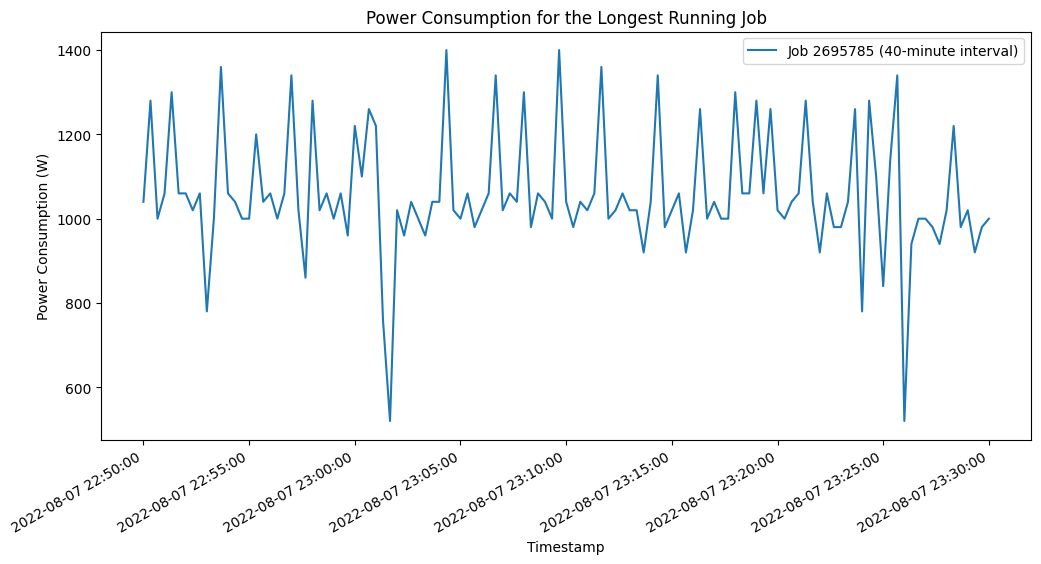

In [11]:
longest_running_job_power[timestamp_col] = pd.to_datetime(longest_running_job_power[timestamp_col])

interval_data = longest_running_job_power[
    (longest_running_job_power[timestamp_col] >= pd.to_datetime(start_time, utc=True)) &
    (longest_running_job_power[timestamp_col] <= pd.to_datetime(start_time, utc=True) + pd.Timedelta(minutes=40))
]

plt.figure(figsize=(12, 6))
plt.plot(interval_data[timestamp_col], interval_data[power_col], label=f'Job {longest_running_job_row["job_id"]} (40-minute interval)')
plt.title(f'Power Consumption for the Longest Running Job')
plt.xlabel('Timestamp')
plt.ylabel('Power Consumption (W)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gcf().autofmt_xdate()  # Auto-format the x-axis date labels for better readability
plt.legend()
plt.show()

### Visualizing the time series of total power consumption in Marconi during the month of August

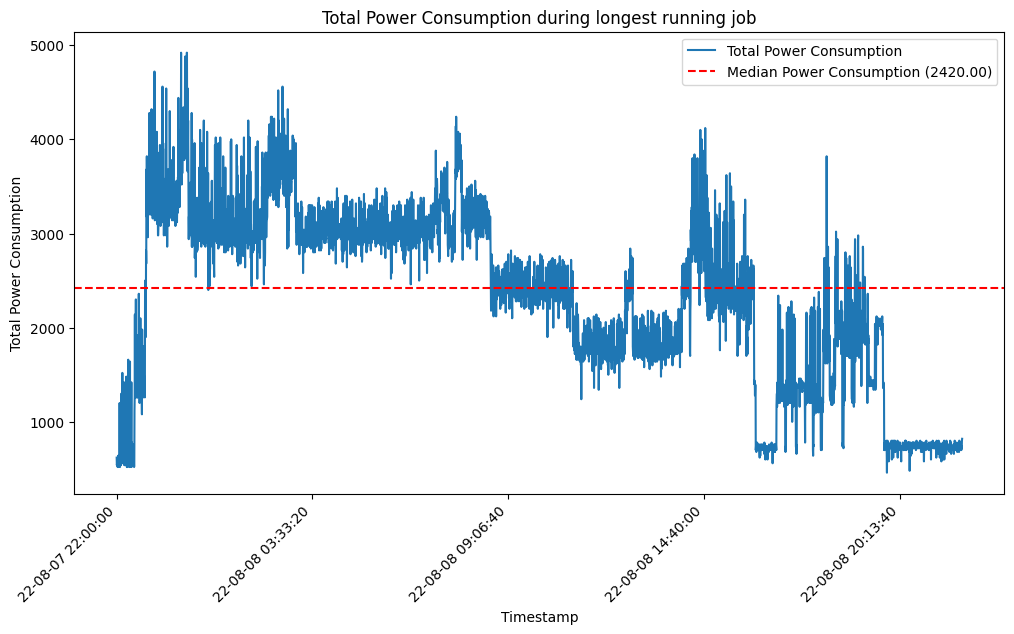

In [12]:
power_data = time_series_analysis_merged_df[[timestamp_col, power_col]]

# Group by timestamp and sum the power consumption values
total_power_by_timestamp = power_data.groupby(timestamp_col)[power_col].sum().reset_index()

median_total_power = total_power_by_timestamp[power_col].median()

plt.figure(figsize=(12, 6))
plt.plot(total_power_by_timestamp[timestamp_col], total_power_by_timestamp[power_col], label='Total Power Consumption')
plt.axhline(y=median_total_power, color='r', linestyle='--', label=f'Median Power Consumption ({median_total_power:.2f})')
plt.title('Total Power Consumption during longest running job')
plt.xlabel('Timestamp')
plt.ylabel('Total Power Consumption')
formatted_ticks = pd.to_datetime(total_power_by_timestamp[timestamp_col][::1000]).dt.strftime('%y-%m-%d %H:%M:%S')
plt.xticks(total_power_by_timestamp[timestamp_col][::1000], formatted_ticks, rotation=45, ha='right')
plt.legend()
plt.show()

### See the work of a single node during the month/week/day

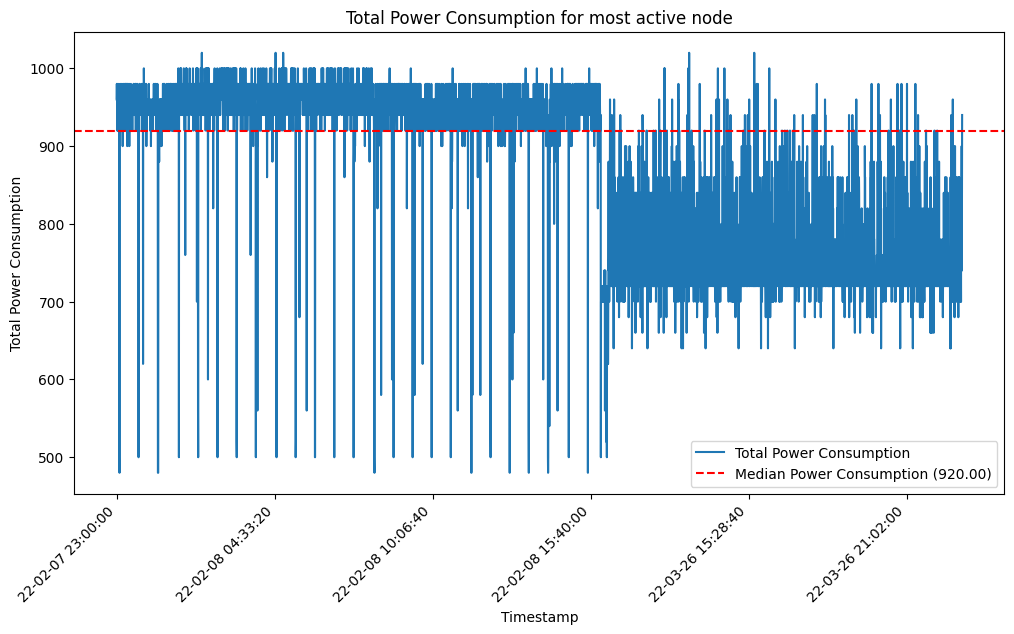

In [13]:
most_active_node_rows = merged_df[merged_df['nodes'] == merged_df['nodes'].value_counts().idxmax()] # get the node with the most activity
power_data = most_active_node_rows[[timestamp_col, power_col]]
total_power_by_timestamp = power_data.groupby(timestamp_col)[power_col].sum().reset_index()
median_total_power = total_power_by_timestamp[power_col].median()

plt.figure(figsize=(12, 6))
plt.plot(total_power_by_timestamp[timestamp_col], total_power_by_timestamp[power_col], label='Total Power Consumption')
plt.axhline(y=median_total_power, color='r', linestyle='--', label=f'Median Power Consumption ({median_total_power:.2f})')
plt.title('Total Power Consumption for most active node')
plt.xlabel('Timestamp')
plt.ylabel('Total Power Consumption')
formatted_ticks = pd.to_datetime(total_power_by_timestamp[timestamp_col][::1000]).dt.strftime('%y-%m-%d %H:%M:%S')
plt.xticks(total_power_by_timestamp[timestamp_col][::1000], formatted_ticks, rotation=45, ha='right')
plt.legend()
plt.show()

### For each user, calculate energy consumption of all their jobs (integral of power/time curve) and sum them, and do it for all users, then calculate histogram with energy consumption for each user

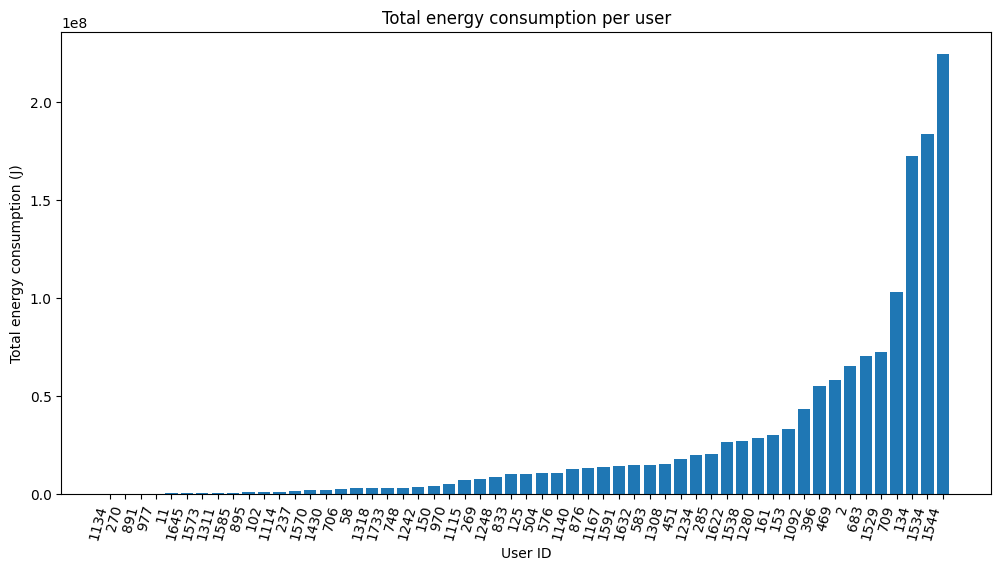

In [14]:
# Data frame to store energy consumption values per user ID
energy_consumption_per_users = pd.DataFrame(columns=['user_id', 'energy_consumed'])

# Data frame to store energy consumption values per user ID and job ID
energy_consumption_per_jobs = pd.DataFrame(columns=['user_id', 'job_id', 'energy_consumed_by_job', 'num_cpus', 'run_time', 'job_state'])

merged_df[timestamp_col] = pd.to_datetime(merged_df[timestamp_col])
      
# Calculate energy consumption for each user by summing up the energy consumed by each of their jobs
for user_id in merged_df['user_id'].unique():
    total_energy_consumed_by_user = 0
    user_data = merged_df[merged_df['user_id'] == user_id]

    for job_id in user_data['job_id'].unique():
        job_data = merged_df[merged_df['job_id'] == job_id]

        # Total energy consumed by the job is the integral of the power consumption time series curve
        total_energy_consumed_by_this_job = np.trapz(job_data[power_col], x=job_data[timestamp_col].astype(int) // 10**9)
        
        # Add this and other relevant info to the job entry on the df
        energy_consumption_per_jobs = pd.concat([energy_consumption_per_jobs, pd.DataFrame({
                                'user_id': [user_id], 
                                'job_id': [job_id], 
                                'total_energy_consumed_by_job': [total_energy_consumed_by_this_job],
                                'num_cpus': [job_data['num_cpus'].iloc[0]],
                                'run_time': [job_data['run_time'].iloc[0]],
                                'job_state': [job_data['job_state'].iloc[0]],
                            })])
        
        # Add total energy of this job to total energy cumulative of the user
        total_energy_consumed_by_user += total_energy_consumed_by_this_job
    
    # Add this user's energy consumption info to the data frame
    energy_consumption_per_users = pd.concat([energy_consumption_per_users, pd.DataFrame({'user_id': [str(user_id)], 'energy_consumed': [total_energy_consumed_by_user]})])

# Group by user_id, sum total energy consumption values then sort rows by energy consumption values in ascending order
energy_consumption_per_users = energy_consumption_per_users.groupby('user_id')['energy_consumed'].sum().reset_index().sort_values(by='energy_consumed')

plt.figure(figsize=(12,6))
plt.bar(energy_consumption_per_users['user_id'].astype(str), energy_consumption_per_users['energy_consumed'])
plt.title('Total energy consumption per user')
plt.xlabel('User ID')
plt.ylabel('Total energy consumption (J)')
plt.xticks(rotation=75, ha='right')
plt.show()


### Calculate the CDF of power consumption per user

2.52% of the users are responsible for 80% of total energy consumption.


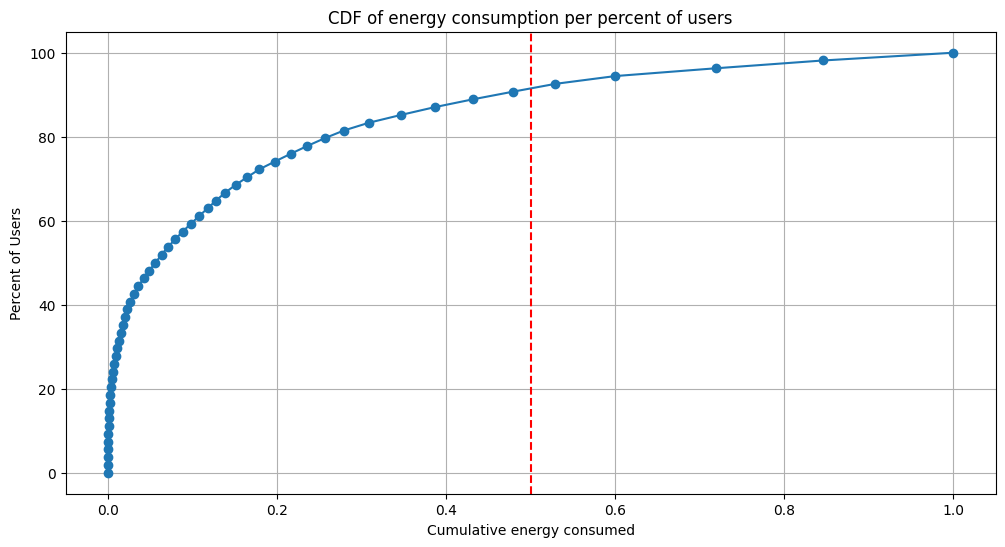

In [15]:
from scipy.interpolate import interp1d

cumulative_percentage = np.linspace(0, 100, len(energy_consumption_per_users))
cumulative_energy = np.cumsum(energy_consumption_per_users['energy_consumed']) / np.sum(energy_consumption_per_users['energy_consumed'])

interp_function = interp1d(cumulative_energy, cumulative_percentage, kind='linear')
percent_half_consumption = 100 - interp_function(0.8)
print(f"{percent_half_consumption:.2f}% of the users are responsible for 80% of total energy consumption.")

plt.figure(figsize=(12,6))
plt.plot(cumulative_energy, cumulative_percentage, marker='o')
plt.axvline(x=0.5, color='red', linestyle='--')
plt.title('CDF of energy consumption per percent of users')
plt.xlabel('Cumulative energy consumed')
plt.ylabel('Percent of Users')
plt.grid(True)
plt.show()

In [16]:
print(energy_consumption_per_users.describe(percentiles=[0.8,0.6,0.95]))

       energy_consumed
count     5.500000e+01
mean      2.638644e+07
std       4.636138e+07
min       3.500000e+04
50%       1.018160e+07
60%       1.408996e+07
80%       3.061816e+07
95%       1.237355e+08
max       2.243166e+08


The large difference between the mean and median suggests that there are some users who consume significantly more energy than others, skewing the average higher. The high standard deviation supports this observation.
 
Also, the top 5% of users (those who consume more than 125,916,700 units of energy) might be an area to focus on for energy-saving measures.

### Correlations between job geometry (number of nodes and CPUs) with total energy consumed by the job

In [17]:
import scipy.stats

# Convert 'num_cpus' to numeric
energy_consumption_per_jobs['num_cpus'] = pd.to_numeric(energy_consumption_per_jobs['num_cpus'])

# Calculate correlations and p-values between total energy consumed by job and its caracteristics
columns = ['total_energy_consumed_by_job', 'num_cpus','run_time']
corr_matrix = energy_consumption_per_jobs[columns].corr()
pval_matrix = energy_consumption_per_jobs[columns].apply(lambda x: energy_consumption_per_jobs[columns].apply(lambda y: scipy.stats.pearsonr(x,y)[1]))

# Create a dataframe for the correlation and p-values
corr_pval_df = pd.DataFrame([(i, j, corr_matrix.loc[i, j], pval_matrix.loc[i, j]) for i in columns for j in columns if i != j], columns = ['Variable 1', 'Variable 2', 'Correlation', 'P-Value'])

print(corr_pval_df[corr_pval_df['Variable 1'] == 'total_energy_consumed_by_job'])

                     Variable 1 Variable 2  Correlation       P-Value
0  total_energy_consumed_by_job   num_cpus    -0.183729  3.690095e-03
1  total_energy_consumed_by_job   run_time     0.730669  1.165063e-42


### Percentage of high consuming jobs per job state
Considering the jobs of the 4 top consuming user IDS. 

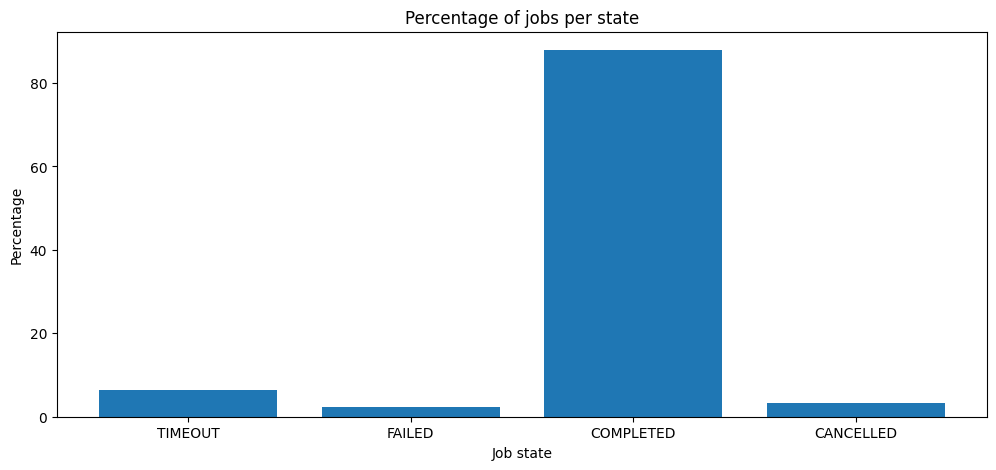

In [18]:
# consumers = energy_consumption_per_users['user_id'].to_list()
# top_consumers_jobs = energy_consumption_per_jobs[energy_consumption_per_jobs['user_id'].isin(consumers)]

job_states = ['TIMEOUT', 'FAILED', 'COMPLETED', 'CANCELLED']
percentages = energy_consumption_per_jobs['job_state'].value_counts(normalize=True).loc[job_states] * 100

plt.figure(figsize=(12,5))
plt.bar(job_states, percentages)
plt.xlabel('Job state')
plt.ylabel('Percentage')
plt.title('Percentage of jobs per state')
plt.show()

### Total energy consumed per job state
Considering the whole dataset.

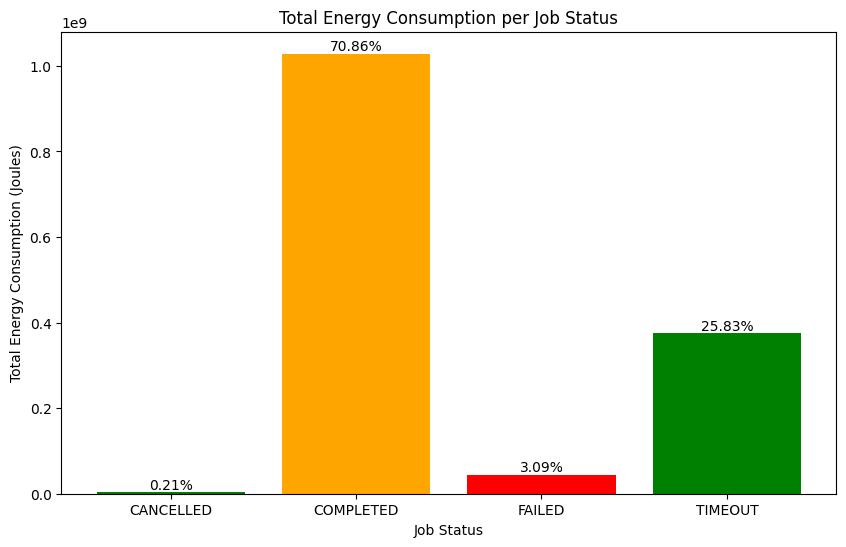

In [19]:
energy_consumption_per_status = energy_consumption_per_jobs.groupby('job_state')['total_energy_consumed_by_job'].sum().reset_index()

# get percentages
total_energy_consumption = energy_consumption_per_status['total_energy_consumed_by_job'].sum()
energy_consumption_per_status['percentage'] = (energy_consumption_per_status['total_energy_consumed_by_job'] / total_energy_consumption) * 100

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(energy_consumption_per_status['job_state'], energy_consumption_per_status['total_energy_consumed_by_job'], color=['green', 'orange', 'red'])

for bar, percentage in zip(bars, energy_consumption_per_status['percentage']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, f'{percentage:.2f}%', ha='center', va='bottom')

plt.title('Total Energy Consumption per Job Status')
plt.xlabel('Job Status')
plt.ylabel('Total Energy Consumption (Joules)')
plt.show()

### Trying to predict job state based on job info prior to execution
Job info being considered: user ID, number of CPUs, start hour, tres per node and time limit chosen by the user.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import RFE

relevant_job_states = ['TIMEOUT', 'FAILED', 'COMPLETED']

def convert_time_limit(time_limit_str):
    # Split the string into components
    components = time_limit_str.split('-')

    # Convert each component to timedelta
    days = int(components[0]) if len(components) > 1 else 0
    time_components = components[-1].split(':')
    hours = int(time_components[0])
    minutes = int(time_components[1]) if len(time_components) > 1 else 0
    seconds = int(time_components[2]) if len(time_components) > 2 else 0

    # Calculate total seconds
    total_seconds = days * 24 * 60 * 60 + hours * 60 * 60 + minutes * 60 + seconds
    return total_seconds

# Read job info pre execution to a dataframe for all months
selected_columns = ['user_id', 'num_cpus', 'time_limit_str', 'job_state', 'start_time', 'gpus_per_node']
job_info_pre_execution = (merged_df[selected_columns]).copy()

# Clean and format columns
job_info_pre_execution['time_limit'] = job_info_pre_execution['time_limit_str'].apply(convert_time_limit)
job_info_pre_execution['start_hour'] = pd.to_datetime(job_info_pre_execution['start_time']).dt.hour

# Filter dataset to include only relevant job states
job_info_pre_execution = job_info_pre_execution[job_info_pre_execution['job_state'].isin(relevant_job_states)]

# Select and extract features and target variable
features = ['user_id', 'num_cpus', 'time_limit', 'start_hour', 'gpus_per_node']
target = 'job_state'

# Use one-hot encoding for 'user_id' column
X_encoded = pd.get_dummies(job_info_pre_execution[features + [target]], columns=['user_id'], prefix='user')

# Split in train and test sets
X = X_encoded.drop(columns=[target])
y = X_encoded[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Do under sampling using a manually defined sampling strategy that balances the counts of each class
timeouted_count = y_train.value_counts()['TIMEOUT']
failed_count = y_train.value_counts()['FAILED']
completed_count = y_train.value_counts()['COMPLETED']
sampling_strategy_dict = {'COMPLETED': failed_count, 'FAILED': failed_count, 'TIMEOUT': failed_count}

rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Build logistic regression model using RFE
model = LogisticRegression(max_iter=10000, random_state=42)

rfe = RFE(estimator=model)
rfe.fit(X_train, y_train)
selected_features = X_train.columns[rfe.support_]
#print(selected_features)
X_resampled_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)

# Fit logistic regression model on the selected features
model.fit(X_resampled_selected, y_train)

# Evaluate the model
predictions = model.predict(X_test_selected)
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

4    81845
1     7460
0     4483
2      938
Name: gpus_per_node, dtype: int64


KeyboardInterrupt: 

### Investigating class distribution of job states

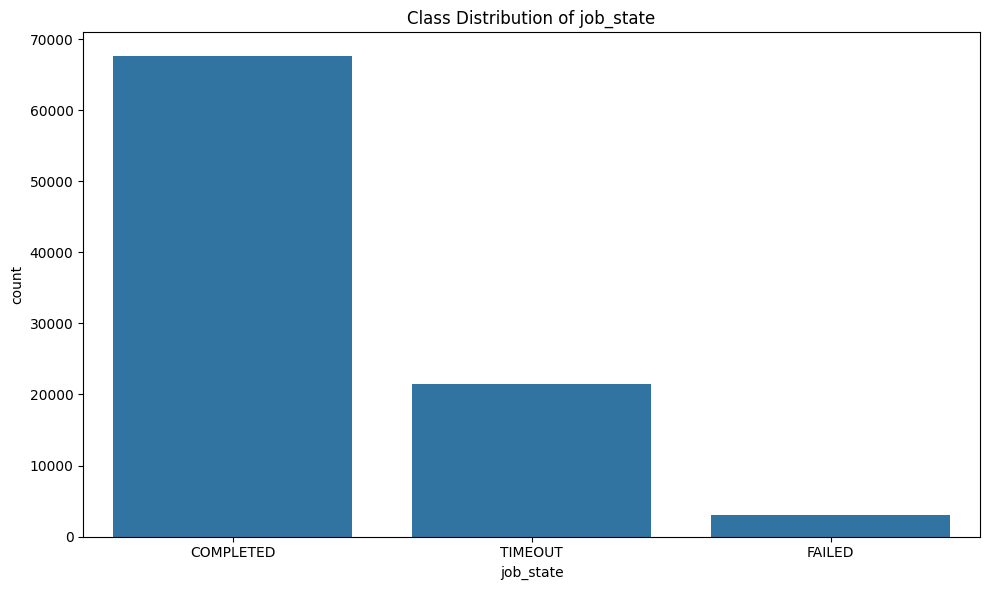

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(x='job_state', data=job_info_pre_execution)
plt.title('Class Distribution of job_state')
plt.tight_layout()
plt.show()

In [43]:

# Create a dataframe with the selected features
selected_features_df = pd.DataFrame(X_test_selected, columns=selected_features)

# One-hot encode the predicted class labels
predicted_classes_one_hot = pd.get_dummies(predictions, prefix='Predicted_Class', columns=model.classes_)

# Concatenate the one-hot encoded columns with the selected features dataframe
selected_features_df = pd.concat([selected_features_df, predicted_classes_one_hot], axis=1)

# Display the updated dataframe
print(selected_features_df.corr())


                           tres_per_node    user_2  user_134  user_153  \
tres_per_node                   1.000000  0.079603 -0.325545  0.056485   
user_2                          0.079603  1.000000 -0.088826 -0.037276   
user_134                       -0.325545 -0.088826  1.000000 -0.063029   
user_153                        0.056485 -0.037276 -0.063029  1.000000   
user_161                        0.054438 -0.035925 -0.060745 -0.025492   
user_269                        0.026162 -0.017265 -0.029193 -0.012251   
user_285                        0.036650 -0.024186 -0.040896 -0.017162   
user_396                        0.063761 -0.042078 -0.071148 -0.029858   
user_451                        0.051528 -0.034005 -0.057498 -0.024129   
user_469                        0.074748 -0.049328 -0.083407 -0.035002   
user_583                        0.039891 -0.026325 -0.044512 -0.018680   
user_683                        0.069515 -0.045875 -0.077569 -0.032552   
user_706                       -0.0826

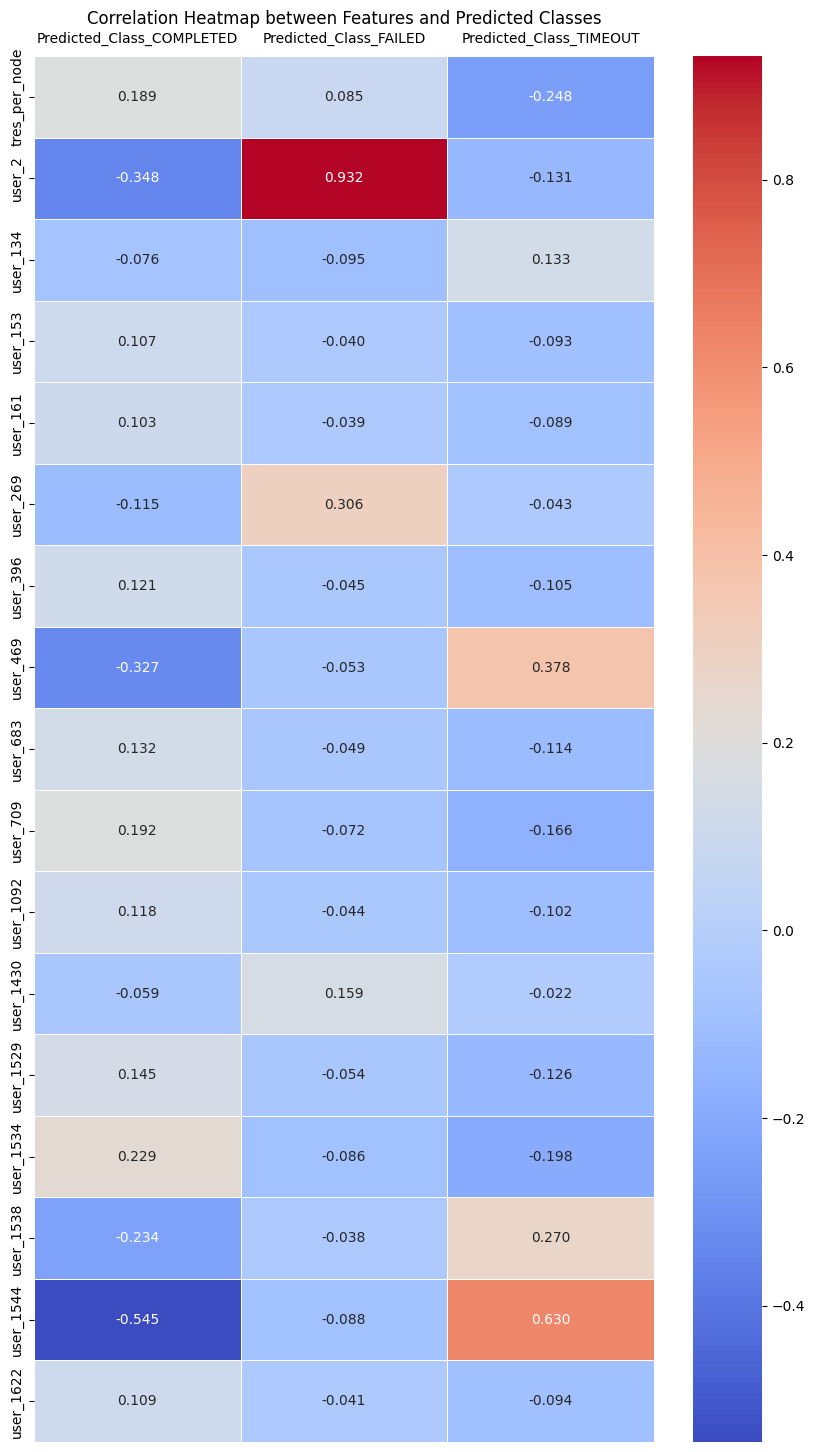

In [46]:
# Remove features with all zero values
non_zero_features = selected_features_df.loc[:, (selected_features_df != 0).any(axis=0)]

# Get correlation values between features and expected values for traget variable job_state
correlation_matrix = non_zero_features.corr().iloc[:-3, -3:]
correlation_matrix = correlation_matrix[~correlation_matrix.apply(lambda x: all(-0.1 <= val <= 0.1 for val in x), axis=1)]

# Plot the correlation heatmap
plt.figure(figsize=(10, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.title('Correlation Heatmap between Features and Predicted Classes')
plt.show()